**Objective:**
This notebook serves as a control panel to generate and verify the mock datasets required for building the interactive GWAS Explorer visualization.

**Workflow:**
1.  **Import Generator:** Import the `generate_all_mock_data` function from our source code script (`src/data/generate_mock_data.py`).
2.  **Run Generator:** Execute the function to create three CSV files in the `/data` directory.
3.  **Load & Verify:** Load each generated CSV back into a pandas DataFrame and display its head.
4.  **Visualize:** Produce a simple Manhattan plot to visually confirm the data's characteristics.

**Conclusion:**
This notebook validates that our data generation script works as expected and produces realistic-looking mock data. This data is now ready to be used as a reliable placeholder for building the main `gwas_explorer.html` dashboard.

###  1. Setup & Imports 

In [1]:
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

if '../src' not in sys.path:
    sys.path.append('../src')
    
from data.generate_mock_data import generate_all_mock_data

# Configure plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 6)

print("Setup complete.")

Setup complete.


### 2. Generate All Mock Data Files
Running the cell below will execute the imported `generate_all_mock_data` function. This will create the `/data` directory at the project root (if it doesn't already exist) and populate it with our required mock data files.

In [2]:
# Execute the data generation script
generate_all_mock_data()

--- Starting Realistic Mock Data Generation ---
Simulating genome-wide scan data...
Generated 500,000 genome-wide SNP results -> ../data/mock_gwas_full_scan.csv
Simulating verification data for top hits...
Generated verification data for 737 significant SNPs -> ../data/mock_verification_hits.csv
Creating mock gene annotation data...
Saved mock gene annotations -> ../data/mock_gene_annotations.csv

--- Mock Data Generation Complete ---


In [3]:
# Load and display the head of each generated file
print("--- Verifying 'mock_gwas_full_scan.csv' ---")
try:
    gwas_full_df = pd.read_csv('../data/mock_gwas_full_scan.csv')
    print("✅ Successfully loaded 'mock_gwas_full_scan.csv'")
    display(gwas_full_df.head())
except FileNotFoundError:
    print("❌ File not found.")


# The filename has been changed to match the new script's output.
print("\n--- Verifying 'mock_verification_hits.csv' ---")
try:
    # Use the new filename here
    verified_hits_df = pd.read_csv('../data/mock_verification_hits.csv')
    print("✅ Successfully loaded 'mock_verification_hits.csv'")
    print(f"Shape of the DataFrame: {verified_hits_df.shape}")
    display(verified_hits_df.head())
except FileNotFoundError:
    print("❌ File not found.")


print("\n--- Verifying 'mock_gene_annotations.csv' ---")
try:
    gene_annotations_df = pd.read_csv('../data/mock_gene_annotations.csv')
    print("✅ Successfully loaded 'mock_gene_annotations.csv'")
    display(gene_annotations_df.head())
except FileNotFoundError:
    print("❌ File not found.")

--- Verifying 'mock_gwas_full_scan.csv' ---
✅ Successfully loaded 'mock_gwas_full_scan.csv'


,contig,pos,p_value,-log10(p)
0,2L,12,0.003302,2.481247
1,2L,66,0.013029,1.885076
2,2L,812,0.114014,0.943043
3,2L,957,0.107243,0.969633
4,2L,1310,0.046399,1.333495



--- Verifying 'mock_verification_hits.csv' ---
✅ Successfully loaded 'mock_verification_hits.csv'
Shape of the DataFrame: (737, 7)


,contig,pos,p_value,-log10(p),log_odds_mixed,ci_lower_mixed,ci_upper_mixed
0,2L,2300641,7.157472e-07,6.145240,1.329753,1.216965,1.564682
1,2L,2300682,4.141848e-07,6.382806,1.003611,0.825908,1.173400
2,2L,2301132,5.636838e-07,6.248964,1.259175,1.031561,1.397396
3,2L,2301398,1.819290e-07,6.740098,1.176956,0.976960,1.369335
4,2L,2301755,2.189542e-07,6.659647,1.026646,0.748446,1.295493



--- Verifying 'mock_gene_annotations.csv' ---
✅ Successfully loaded 'mock_gene_annotations.csv'


,contig,start,end,gene_name,strand
0,2L,2358158,2431617,Vgsc,+
1,2L,2800000,2805000,GeneB,-
2,3R,21400000,21408000,GeneC,+


### 3. Visual Confirmation
To visually confirm our simulation, we'll create a simple Manhattan plot using the loaded genome-wide scan data. We expect to see a background of low-significance points and clear "skyscrapers" at our simulated hit locations on chromosomes 2L and 3R.

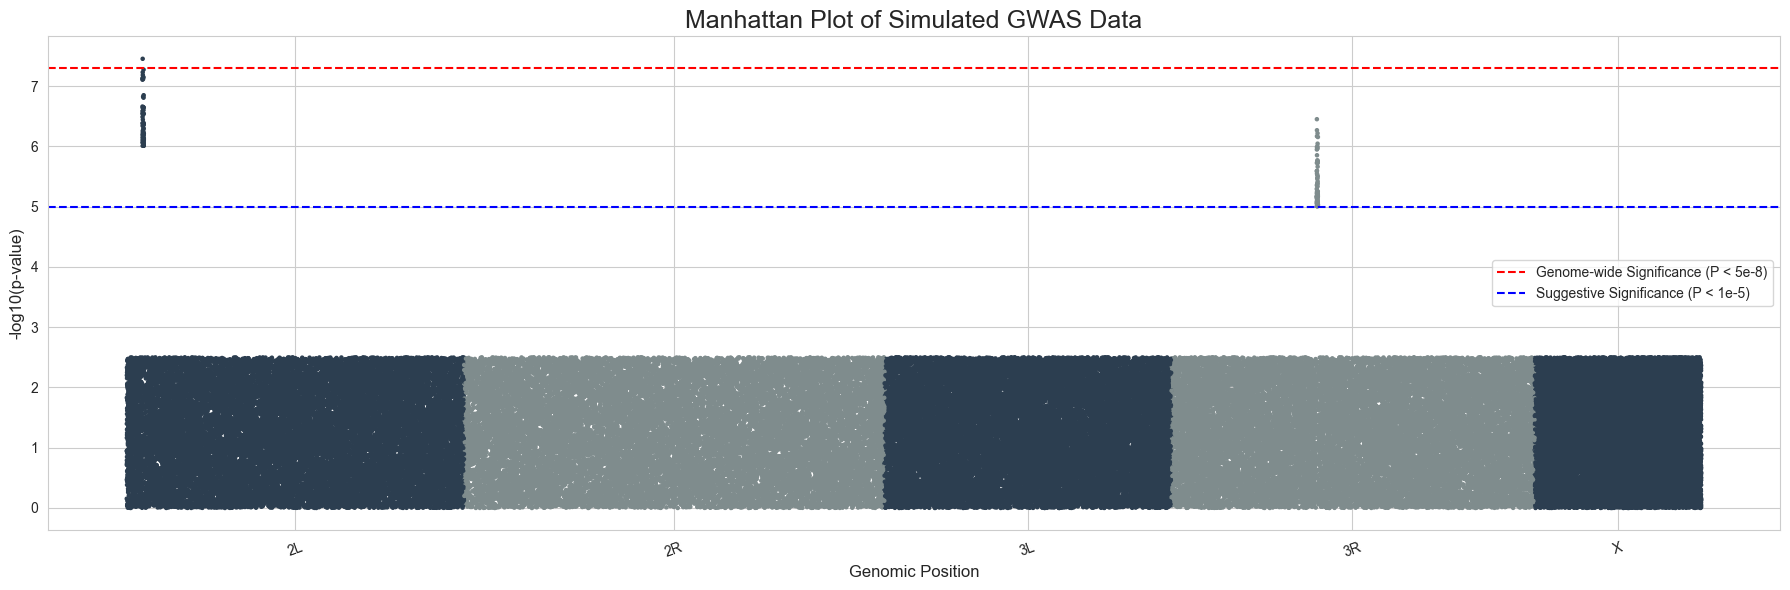

In [4]:
def plot_mock_manhattan(df):
    """A simple function to create a verification plot."""
    # Create a numeric x-axis for the plot
    df['contig_cat'] = pd.Categorical(df['contig'], categories=['2L', '2R', '3L', '3R', 'X'], ordered=True)
    df = df.sort_values(['contig_cat', 'pos'])
    df['pos_cumulative'] = 0
    cumulative_pos = 0
    contig_centers = []
    contig_labels = []
    
    for contig in ['2L', '2R', '3L', '3R', 'X']:
        subset = df[df['contig'] == contig]
        if not subset.empty:
            df.loc[subset.index, 'pos_cumulative'] = subset['pos'] + cumulative_pos
            contig_centers.append(cumulative_pos + subset['pos'].median())
            contig_labels.append(contig)
            cumulative_pos += subset['pos'].max()

    # Create color mapping
    df['color'] = df['contig_cat'].cat.codes.apply(lambda x: '#2c3e50' if x % 2 == 0 else '#7f8c8d')

    # Downsample for a fast plot in the notebook
    plot_sample = df.sample(n=100000, random_state=42) if len(df) > 100000 else df

    # Plot
    plt.figure(figsize=(18, 6))
    plt.scatter(plot_sample['pos_cumulative'], plot_sample['-log10(p)'], c=plot_sample['color'], s=5)
    plt.axhline(y=-np.log10(5e-8), color='red', linestyle='--', label='Genome-wide Significance (P < 5e-8)')
    plt.axhline(y=-np.log10(1e-5), color='blue', linestyle='--', label='Suggestive Significance (P < 1e-5)')
    
    plt.xticks(ticks=contig_centers, labels=contig_labels, rotation=20)
    plt.title('Manhattan Plot of Simulated GWAS Data', fontsize=18)
    plt.xlabel('Genomic Position', fontsize=12)
    plt.ylabel('-log10(p-value)', fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Use the function on our loaded DataFrame
plot_mock_manhattan(gwas_full_df)